In this project ....

We will simulate a very simple system consisting of a cart driven by a DC motor. The states of the system are the cart's _position_ $x_1$, its _velocity_ $x_2$, and the applied _armature current_ $x_3$, such that the state vector is given by
$$
\mathbf{x} = 
\begin{bmatrix}
x_1 \\ x_2 \\ x_3
\end{bmatrix}.
$$

To model this system, we must establish the relationship between the state variables. For the position and velocity, the relationship is simply 
$$
\dot{x}_1 = x_2.
$$

For the velocity and the armature current, we begin by investigating the forces acting on the cart. They are the driving force $F_M$ developed by the electric motor, and the opposing friction $F_r$ (we ignore the air resistance). In sum, the cart's acceleration is given by
$$
\dot{x}_2 = \frac{F_M - F_r}{m},
$$
where $m$ is the mass of the cart. The motor force is proportional to the torque, $T_M$, and the torque developed by DC motor is again proportional to the applied armature current, such that
$$
F_M = k_M T_M = k_M'x_3.
$$
Here, $k_M$ contains all factors relating to the mechanical transmission of power from the rotor to the surface which the cart's wheels are rubbing against, while $k_M'$ in addition to that accounts for the electromagnetics, such as flux density and physical constants. In the case we are studying here, the friction increases linearly with velocity;
$$
F_r = k_r x_2,
$$
where $k_r$ is the friction constant. This kind of friction is typical for an object moving slowly through a viscous without creating turbulence. The resulting relationship between velocity and armature current is
$$
\dot{x}_2 = \frac{-k_r}{m}x_2 + \frac{k_M'}{m}x_3.
$$

We can only control the cart's position and velocity through the armature current. A step change in setpoint from a steady-state $u^-$ to $u^+$ at time $t=0$ gives an exponential response in the armature current due to electrical impedance, such that
$$
x_3 = u^- + \big( 1 - e^{-t/\tau_a} \big) \big( u^+ - u^- \big), \quad t \ge 0.
$$
Time derivation gives us
$$
\dot{x}_3 = \frac{1}{\tau_a} \bigg[ \big( u^+ - u^- \big)e^{-t/\tau_a} \bigg],
$$
and rearranging the equation for $x_3$ gives us that
$$
x_3 = u^+ - \bigg[ \big( u^+ - u^- \big)e^{-t/\tau_a} \bigg] = u^+ - \tau_a \dot{x}_3,
$$
which results in
$$
\dot{x}_3 = \frac{-1}{\tau_a} x_3 + \frac{1}{\tau_a} u^+.
$$

Finally, the system equiation becomes
$$
\dot{\mathbf{x}} = \mathbf{F}\mathbf{x} + \mathbf{L}u
\quad \Rightarrow \quad
\begin{bmatrix}
\dot{x}_1 \\ \dot{x}_2 \\ \dot{x}_3
\end{bmatrix}
=
\begin{bmatrix}
0 & 1 & 0 \\
0 & \frac{-k_r}{m} & \frac{k_M'}{m} \\
0 & 0 & \frac{-1}{\tau}
\end{bmatrix}
\begin{bmatrix}
x_1 \\ x_2 \\ x_3
\end{bmatrix}
+
\begin{bmatrix}
0 \\ 0 \\ \frac{1}{\tau_a}
\end{bmatrix}
u.
$$

# 1 Simulation Model $\mathcal{M^S}$

In the assignment, we are given the following parameters to work with:
$$
\frac{k_r}{m} = \frac{k_M'}{m} = \frac{1}{T_2}, \quad \text{and} \quad \tau_a = T_3.
$$
Looking at the second system equation, for velocity $x_2$, we see that it has similar shape as the armature current equation. The equality $k_r = k_M'$ thus means that the value of $x_2, x_3$ and $u$ are equal in the steady state. Also, we should expect a similar exponential response in $x_2$ to a step change in $x_3$ as we saw for the armature current equation above, only with a time constant $T_2$ instead of $T_3$. However, since change in $x_2$ is a reaction to change in $x_3$, and $x_3$ is a reaction to (instant) change in $u$, the response in $x_2$ will be slower than what we should expect from its time constant alone.

The assignment also provides us with a noise term in the system equation, affecting only armature current, such that the equation gets the form
$$
\dot{\mathbf{x}} = \mathbf{F}\mathbf{x} + \mathbf{L}u + \mathbf{G}v
\quad \Rightarrow \quad
\begin{bmatrix}
\dot{x}_1 \\ \dot{x}_2 \\ \dot{x}_3
\end{bmatrix}
=
\begin{bmatrix}
0 & 1 & 0 \\
0 & \frac{-1}{T_2} & \frac{1}{T_2} \\
0 & 0 & \frac{-1}{T_3}
\end{bmatrix}
\begin{bmatrix}
x_1 \\ x_2 \\ x_3
\end{bmatrix}
+
\begin{bmatrix}
0 \\ 0 \\ \frac{1}{T_3}
\end{bmatrix}
u
+
\begin{bmatrix}
0 \\ 0 \\ 1
\end{bmatrix}
v, \quad v \sim \mathcal{N}(0, \tilde{\mathbf{Q}} \delta(t-\tau)).
$$

We will assume initial state estimate $\hat{\mathbf{x}}_0 = \mathbf{0}$, such that the initial estimate error covariance becomes
$$
\mathbf{x}_0 = \hat{\mathbf{e}}_0 \sim \mathcal{N}(0, \hat{\mathbf{P}}_0).
$$
We will also assume measurement of position only, such that the measurement equation can be written
$$
\mathbf{z}_k = \mathbf{Hx} + \mathbf{w}_k
\quad \Rightarrow \quad
z_k = 
\begin{bmatrix}
1 & 0 & 0
\end{bmatrix}
\mathbf{x}
+ w_k, \quad w_k \sim \mathcal{N}(0, \mathbf{R} \delta_{kl}).
$$


Having established the system equation and roughly what to expect in terms of changes in the control parameter $u$, we are ready to run simulations. But, before we start, let's set up our Python environment: 

In [28]:
### Setting up environment
%load_ext autoreload
import numpy as np
from numpy import sqrt
from scipy.linalg import expm, inv, norm, cholesky as chol
import matplotlib.pyplot as plt
from tqdm import tqdm

### Setting plotting style
plt.style.use('fivethirtyeight')
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

### Seed the RNG
np.random.seed(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's also define a function which will help us give matrices a square form by padding them with zeros along the missing rows or columns: 

In [29]:
def pad_to_square(A, n=None):
    '''Zero pads matrix A to square shape'''
    nx, ny = A.shape
    if n is None:
        n = max(nx, ny)
    B = np.zeros((n,n))
    B[:nx, :ny] = A
    return B

Parameters for the simulation model are listed below.

In [30]:
# Simulation parameters
t0, tf = 0, 100
dt = .01

# System parameters
T2, T3 = 5, 1
Q = np.eye(3)*2*.1**2
F = np.array([[0, 1, 0],
              [0, -1/T2, 1/T2],
              [0, 0, -1/T3]])
L = np.array([[0, 0, 0],
              [0, 0, 0],
              [0, 0, 1/T3]])
G = np.array([[0, 0, 0],
              [0, 0, 0],
              [0, 0, 1]])

# Kalman filter parameters
P0 = np.diag([1, .1**2, .1**2])
R = np.eye(3)*1
H = np.array([[1, 0, 0],
              [0, 0, 0],
              [0, 0, 0]])

# 2 Discretization

To implement the system equation in a computer program we need first to discretize it into the form
$$
\mathbf{x}_{x+1} = \mathbf{\Phi}\mathbf{x}_k + \mathbf{\Lambda}\mathbf{u}_k + \mathbf{\Gamma}\mathbf{v}_k, \quad \mathbf{v}_k \sim \mathcal{N}(0, \mathbf{Q} \delta_{kl}).
$$
Here, $\mathbf{u}_k = [u_k, 0, 0]^T$ and $\mathbf{v}_k = [0, 0, v_k]^T$. We also point out that $\tilde{\mathbf{Q}}$ in the continuous equation is the process noise power spectral density matrix -- which is a continuous function in $\mathbb{R}^{n \times n}$ -- and that the corresponding factor in the discrete equation $\mathbf{Q}$ is the discrete process noise autocorrelation matrix.

The discrete system matrices $\mathbf{\Phi}, \mathbf{\Lambda}$ are found by first re-writing the deterministic part of the continuous system equation as
$$
\dot{\tilde{\mathbf{x}}} = \tilde{\mathbf{F}}\tilde{\mathbf{x}} = 
\begin{bmatrix}
\mathbf{F} & \mathbf{L} \\
\mathbf{0} & \mathbf{0}
\end{bmatrix}
\begin{bmatrix}
\mathbf{x} \\
\mathbf{u}
\end{bmatrix}.
$$
Then, the corresponding deterministic discrete equation becomes
$$
\tilde{\mathbf{x}}_{k+1} = \tilde{\mathbf{\Phi}}\tilde{\mathbf{x}}_k, 
\quad \text{where} \quad 
\tilde{\mathbf{\Phi}} = e^{\tilde{\mathbf{F}} \Delta t} =
\begin{bmatrix}
\mathbf{\Phi} & \mathbf{\Lambda} \\
\mathbf{0} & \mathbf{I}
\end{bmatrix},
$$
and we assume that $u$ is constant over the time interval $[t_k, t_k + \Delta t]$. An implementation follows below.

In [31]:
def c2d_determnistic(F, L, dt):
    '''Converts the continuous process equation matrices F, L into discrete matrices Fi, La with time step dt'''
    p = F.shape[0]
    F1 = pad_to_square(np.hstack((F, L)), n=2*p)
    Fi1 = expm(F1*dt)
    Fi = Fi1[:p, :p]  # Upper left
    La = Fi1[:p, p:]  # Upper right
    
    return (Fi, La)

Running this with the input defined in the assignment we ge get the result printed below. We note that the discretized control input matrix $\Lambda$ does not have all-zeros in the first and second rows, for the position and velocity equations. The reason for this is that we account for the effect on position and velocity in the time interval $[t_k, t_k + \Delta t]$, which follows from the matrix superposition integral:
$$
\mathbf{\Lambda}\mathbf{u}_k = \int_{t_k}^{t_k + \Delta t} \mathbf{\Phi}\mathbf{L}\mathbf{u}(\tau) d\tau .
$$

In [32]:
Fi, La = c2d_determnistic(F, L, dt)
Fi, La

(array([[1.00000000e+00, 9.99000666e-03, 9.96010313e-06],
        [0.00000000e+00, 9.98001999e-01, 1.98804123e-03],
        [0.00000000e+00, 0.00000000e+00, 9.90049834e-01]]),
 array([[0.00000000e+00, 0.00000000e+00, 3.32335397e-08],
        [0.00000000e+00, 0.00000000e+00, 9.96010313e-06],
        [0.00000000e+00, 0.00000000e+00, 9.95016625e-03]]))

Moving on, we find $\mathbf{\Gamma}$ in a similar way as above by considering only the stochastic part of the continuous system equation, such that
$$
\dot{\tilde{\tilde{\mathbf{x}}}} = \tilde{\tilde{\mathbf{F}}} \tilde{\tilde{\mathbf{x}}} = 
\begin{bmatrix}
\mathbf{F} & \mathbf{G}\tilde{\mathbf{Q}}\mathbf{G}^T \\
\mathbf{0} & -\mathbf{F}^T
\end{bmatrix}
\begin{bmatrix}
\mathbf{x} \\
\mathbf{z}'
\end{bmatrix},
$$
This is the solution of the Riccati equation for the error covariance;
$$
\dot{\mathbf{P}} = \mathbf{FP} + \mathbf{FP}^T - \mathbf{PH}^T \mathbf{R}^{-1} \mathbf{HP} + \mathbf{G}\tilde{\mathbf{Q}}\mathbf{G}^T,
$$
and $\mathbf{z}'$ in the augmented state vector is defined such that
$$
\mathbf{P}\mathbf{z}' = \mathbf{x}.
$$
We then get that the stochastic part of the system equation can be discretized as
$$
\tilde{\tilde{\mathbf{x}}}_{k+1} = \tilde{\tilde{\mathbf{\Phi}}} \tilde{\tilde{\mathbf{x}}}_k, 
\quad \text{where} \quad 
\tilde{\tilde{\mathbf{\Phi}}} = e^{\tilde{\tilde{\mathbf{F}}} \Delta t} =
\begin{bmatrix}
\tilde{\tilde{\mathbf{\Phi}}}_{11} & \tilde{\tilde{\mathbf{\Phi}}}_{12} \\
\mathbf{0} & \tilde{\tilde{\mathbf{\Phi}}}_{22}
\end{bmatrix},
$$
where
$$
\mathbf{\Phi} = \tilde{\tilde{\mathbf{\Phi}}}_{11}, \quad \text{and} \quad \mathbf{\Gamma}\mathbf{Q}\mathbf{\Gamma}^T = \tilde{\tilde{\mathbf{\Phi}}}_{12} \tilde{\tilde{\mathbf{\Phi}}}_{22}^{-1}.
$$
By letting $\mathbf{Q} = \mathbf{I}$, and hence scaling $\mathbf{\Gamma}$ correspondingly, we find $\mathbf{\Gamma}$ by the upper Cholesky factorization
$$
\mathbf{\Gamma} = \mathrm{chol}_u \bigg[ \tilde{\tilde{\mathbf{\Phi}}}_{12} \tilde{\tilde{\mathbf{\Phi}}}_{22}^{-1} \bigg].
$$
An implementation of this is given here:

In [33]:
def c2d_stochastic(F, L, G, Q, dt):
    '''Converts the continuous process equation matrices F, L, G, Q into discrete matrices Fi, La, Ga with time step dt'''
    p = F.shape[0]
    F2 = np.vstack((np.hstack((F, pad_to_square(G@Q@G.T, n=p))),
                    np.hstack((np.zeros(F.shape), -F.T))))
    Fi2 = expm(F2*dt)
    Fi12 = Fi2[:p, p:]  # Upper right
    Fi22 = Fi2[p:, p:]  # Lower right
    Ga = chol(Fi12 @ inv(Fi22), lower=False)
    Fi, La = c2d_determnistic(F, L, dt)
    
    return (Fi, La, Ga)

Running this again with the parameters defined in the assignment we get the result shown below. We note again that the contribution from process noise is not restricted to armature current, and that this again results from the matrix superposition integral applied on the noise:
$$
\mathbf{\Gamma}\mathbf{v}_k = \int_{t_k}^{t_k + \Delta t} \mathbf{\Phi}\mathbf{G}\mathbf{v}(\tau) d\tau .
$$

In [34]:
Fi, La, Ga = c2d_stochastic(F, L, G, Q, dt)
Fi, La, Ga

(array([[1.00000000e+00, 9.99000666e-03, 9.96010313e-06],
        [0.00000000e+00, 9.98001999e-01, 1.98804123e-03],
        [0.00000000e+00, 0.00000000e+00, 9.90049834e-01]]),
 array([[0.00000000e+00, 0.00000000e+00, 3.32335397e-08],
        [0.00000000e+00, 0.00000000e+00, 9.96010313e-06],
        [0.00000000e+00, 0.00000000e+00, 9.95016625e-03]]),
 array([[6.30352113e-08, 1.57378158e-05, 1.04656845e-02],
        [0.00000000e+00, 4.07432794e-06, 8.14187293e-03],
        [0.00000000e+00, 0.00000000e+00, 4.71090429e-03]]))

# 3 Simulation of Stochastic System

We will now simulate the system, first as a purely deterministic process, and then as a stochastic process (i.e. including process noise). We define two methods, one which runs a simulation of the deterministic process, and one which runs a simulation of a stochastic process:

In [35]:
def run_deterministic(u, Fi, La):
    '''Runs simulation of deterministic system Fi, La with control vector u.'''
    _, n = u.shape
    x = np.zeros(u.shape)
    
    for k in range(n-1):
        x[:,k+1,np.newaxis] = Fi@x[:,k,np.newaxis] + La@u[:,k,np.newaxis]
    
    return x

In [36]:
def run_stochastic(u, v, Fi, La, Ga):
    '''Runs simulation of stochastic system Fi, La, Ga with control vector u and noise vector v.'''
    _, n = u.shape
    x = np.zeros(u.shape)
    
    for k in range(n-1):
        x[:,k+1,np.newaxis] = Fi@x[:,k,np.newaxis] + La@u[:,k,np.newaxis] + Ga@v[:,k,np.newaxis]
    
    return x

In the assignment, we are given a fixed control input $u = 1$, such that we can define the control vector ```u``` as ...

In [37]:
t = np.arange(0., tf+dt, dt)
n = t.size
u = np.zeros((3,n))
u[2,:] = 1
u

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.]])

... and run the deterministic process simulation which is stored in the vector ```xd```:

In [38]:
# Deterministic process
Fi, La = c2d_determnistic(F, L, dt)
xd = run_deterministic(u, Fi, La)

For the stochastic process we define in addition a noise vector ```v``` and run the stochastic process simulation which we store in vector ```xs```:

In [39]:
v = np.zeros((3,n))
v[2,:] = np.random.randn(n)
Fi, La, Ga = c2d_stochastic(F, L, G, Q, dt)
xs = run_stochastic(u, v, Fi, La, Ga)

Below we see a plot of each of the processes, showing the armature current control input $u(k)$, the deterministic velocity estimate $\hat{x}_2^{(d)}(k)$, and the stochastic estimate $\hat{x}_2^{(s)}(k)$. The velocity transient response to the step change in $u$ is eponential, as we expected from the discussion above, and we see that it is slighly damped due to the damped reponse in armature current $x_3$. Further, and also as expected, we see that there is a 1-to-1 relationship bewtween the control input and the velocity in the steady state, except of course for the noise effect in the stochastic case. 

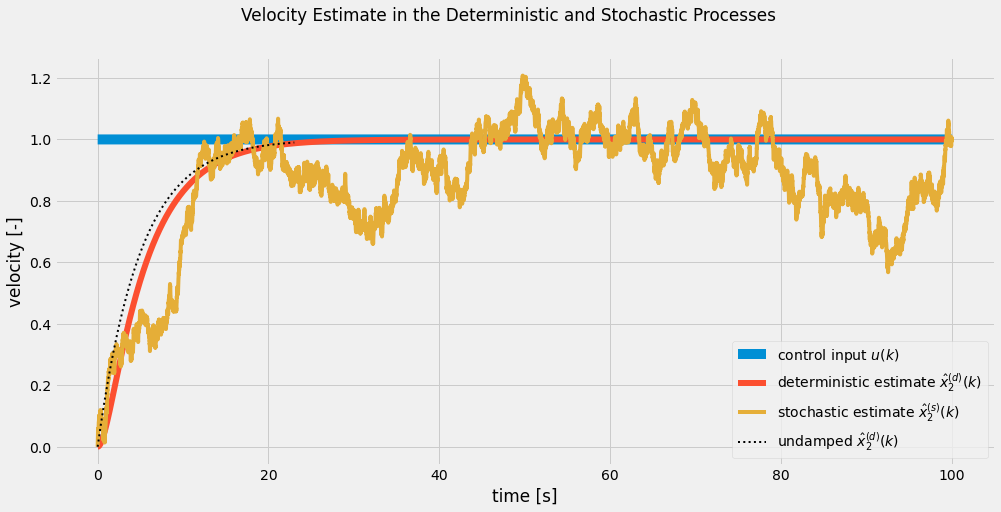

In [40]:
fig, axes = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=True, figsize=(15,7))
fig.suptitle(r'Velocity Estimate in the Deterministic and Stochastic Processes')

ax = axes
ax.plot(t, u[2], lw=10)
ax.plot(t, xd[1], lw=6)
ax.plot(t, xs[1], lw=4)
ax.plot(t[(m:=(x:=1-np.exp(-t/T2))<.99)], x[m], lw=2, ls=':', color='0')
ax.legend([r'control input $u(k)$', r'deterministic estimate $\hat{x}_2^{(d)}(k)$', r'stochastic estimate $\hat{x}_2^{(s)}(k)$', r'undamped $\hat{x}_2^{(d)}(k)$'])
ax.set_xlabel('time [s]')
ax.set_ylabel('velocity [-]')
plt.show()

# 4 Optimal Kalman Filter

In [41]:
def run_kalman(z, u, Fi, La, Ga, P0, H, R, mi, suboptimal=False):
    '''Runs Kalman filter simulation'''
        
    # System order and simulation length
    p, nm = z.shape
    _, n = u.shape
    I = np.eye(p)
    
    # State vector estimates
    x_bar = np.zeros((p,n))  # a-priori
    x_hat = np.zeros((p,nm))  # a-posteriori

    # Covariance matrice estimates
    P_bar = np.zeros((n,p,p))  # a-priori
    P_bar[0,...] = P0
    P_hat = np.zeros((nm,p,p))  # a-posteriori
    
    # Run simulation
    for k in range(n-1):
        
        # Measurement update
        if k%mi == 0:
            km = k//mi
            
            # Compute Kalman gain
            Kk = P_bar[k]@H.T@inv(H@P_bar[k]@H.T + R)

            # Update a-posteriori estimates
            x_hat[:,km,np.newaxis] = x_bar[:,k,np.newaxis] + Kk@(z[:,km,np.newaxis] - H@x_bar[:,k,np.newaxis])
            P_hat[km] = (I - Kk@H)@P_bar[k,...]
            
            if suboptimal:
                P_hat[km] = P_hat[km]@(I - Kk@H).T + Kk@R@Kk.T
            
            xk = x_hat[:,km,np.newaxis]
            Pk = P_hat[km]

        # Time update - update a-priori estimates
        x_bar[:,k+1,np.newaxis] = Fi@xk + La@u[:,k,np.newaxis]
        P_bar[k+1] = Fi@Pk@Fi.T + Ga@Ga.T
    
    # Extract diagonals
    p_bar = np.array([P_bar[:,i,i] for i in range(p)])
    p_hat = np.array([P_hat[:,i,i] for i in range(p)])
    
    return (x_bar, x_hat, p_bar, p_hat)


In [42]:
# Measurement update interval
mi = 100

# Kalman filter matrices
FiK, LaK, GaK = c2d_stochastic(F, L, G, Q, dt*mi)

# Take measurements
xm = xs[:,:-1:mi]
_, nm = xm.shape
w = np.zeros((3,nm))
w[0] = np.random.randn(nm)
z = H@xm + w

# Run simulation
(x_bar, x_hat, p_bar, p_hat) = run_kalman(z, u, FiK, LaK, GaK, P0, H, R, mi)
e_bar = xs - x_bar
e_hat = xm - x_hat

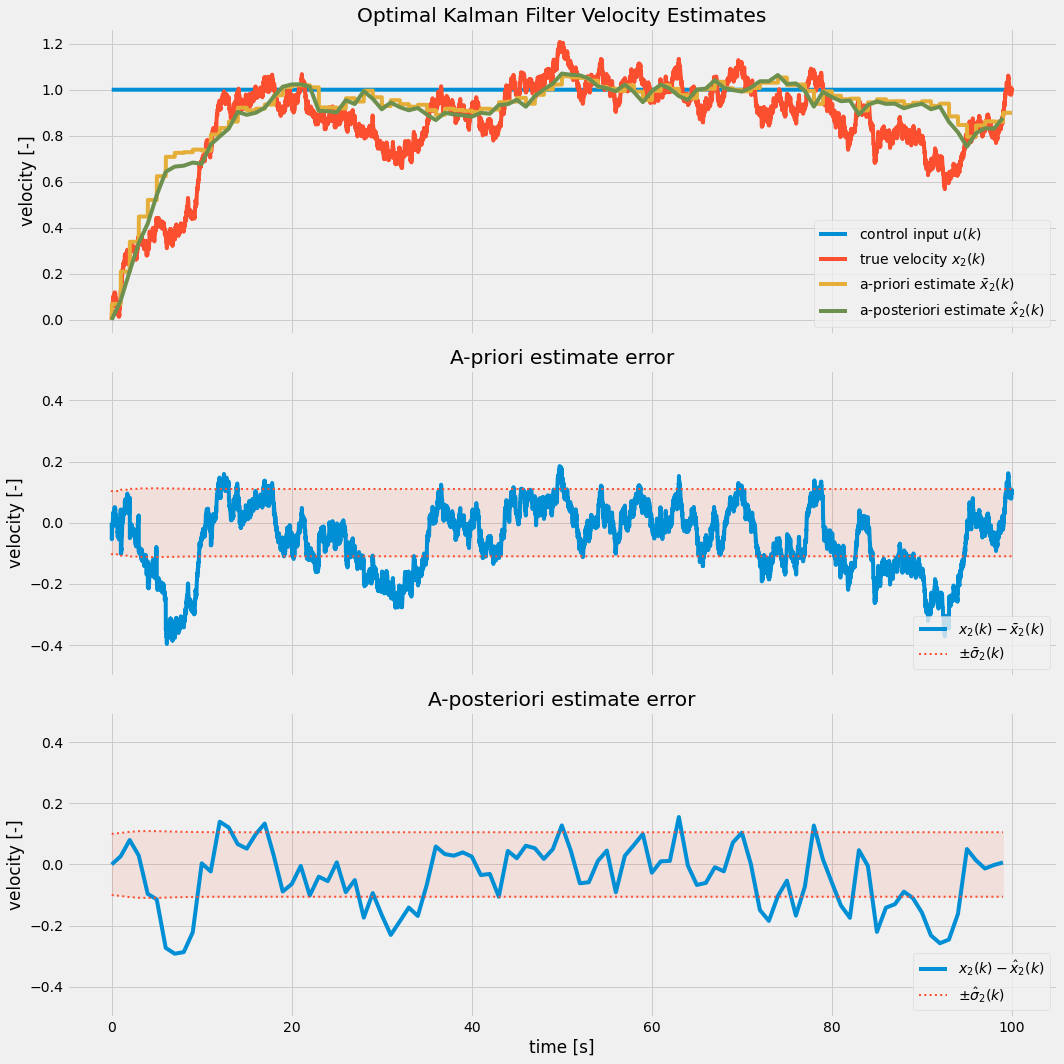

In [50]:
fig, axes = plt.subplots(ncols=1, nrows=3, sharex=True, sharey=False, figsize=(15,15))
#fig.suptitle(r'Optimal Kalman Filter Velocity Estimates')

tm = np.linspace(t0, tf, nm, endpoint=False)

ax = axes[0]
ax.set_title('Optimal Kalman Filter Velocity Estimates')
ax.plot(t, u[2])
ax.plot(t, xs[1])
ax.plot(t, x_bar[1])
ax.plot(tm, x_hat[1])
ax.legend([r'control input $u(k)$', r'true velocity $x_2(k)$', r'a-priori estimate $\bar{x}_2(k)$', r'a-posteriori estimate $\hat{x}_2(k)$'])
ax.set_ylabel('velocity [-]')

ax = axes[1]
ax.set_title('A-priori estimate error')
ax.plot(t, e_bar[1])
ax.plot(t, sqrt(p_bar[1]), color=COLORS[1], lw=2, ls=':')
ax.plot(t, -sqrt(p_bar[1]), color=COLORS[1], lw=2, ls=':')
ax.fill_between(t, sqrt(p_bar[1]), -sqrt(p_bar[1]), color=COLORS[1], alpha=.1)
ax.set_ylim((-.5,.5))
ax.legend([r'$x_2(k) - \bar{x}_2(k)$', r'$\pm \bar{\sigma}_2(k)$'], loc='lower right')
ax.set_ylabel('velocity [-]')

ax = axes[2]
ax.set_title('A-posteriori estimate error')
ax.plot(tm, e_hat[1])
ax.plot(tm, sqrt(p_hat[1]), color=COLORS[1], lw=2, ls=':')
ax.plot(tm, -sqrt(p_hat[1]), color=COLORS[1], lw=2, ls=':')
ax.fill_between(tm, sqrt(p_hat[1]), -sqrt(p_hat[1]), color=COLORS[1], alpha=.1)
ax.set_ylim((-.5,.5))
ax.legend([r'$x_2(k) - \hat{x}_2(k)$', r'$\pm \hat{\sigma}_2(k)$'], loc='lower right')
ax.set_ylabel('velocity [-]')
ax.set_xlabel('time [s]')


fig.tight_layout()
plt.show()

# 5 Monte Carlo simulation of optimal system

In [51]:
def monte_carlo(N):
    # Measurement update interval
    mi = 100

    # Kalman filter model matrices
    FiK, LaK, GaK = c2d_stochastic(F, L, G, Q, dt*mi)

    # Stochastic system model matrices
    FiS, LaS, GaS = c2d_stochastic(F, L, G, Q, dt)

    # Run simulations
    X_bar, X_hat, E_bar, E_hat = list(), list(), list(), list()
    for i in tqdm(range(N)):
        # New stochasitic process simulation
        v = np.zeros((3,n))
        v[2] = np.random.randn(n)
        xs = run_stochastic(u, v, FiS, LaS, GaS)

        # Take measurements
        xm = xs[:,:-1:mi]
        _, nm = xm.shape
        w = np.zeros((3,nm))
        w[0] = np.random.randn(nm)
        z = H@xm + w

        # Run Kalman filter simulation
        (x_bar, x_hat, p_bar, p_hat) = run_kalman(z, u, FiK, LaK, GaK, P0, H, R, mi)
        X_bar.append(x_bar)
        X_hat.append(x_hat)
        E_bar.append(xs-x_bar)
        E_hat.append(xm-x_hat)

    X_bar = np.concatenate(X_bar).reshape(N,3,-1)
    X_hat = np.concatenate(X_hat).reshape(N,3,-1)
    E_bar = np.concatenate(E_bar).reshape(N,3,-1)
    E_hat = np.concatenate(E_hat).reshape(N,3,-1)
    
    return (X_bar, X_hat, E_bar, E_hat, p_bar, p_hat)

In [63]:
(X_bar, X_hat, E_bar, E_hat, p_bar, p_hat) = monte_carlo(10)

100%|██████████| 10/10 [00:01<00:00,  5.80it/s]


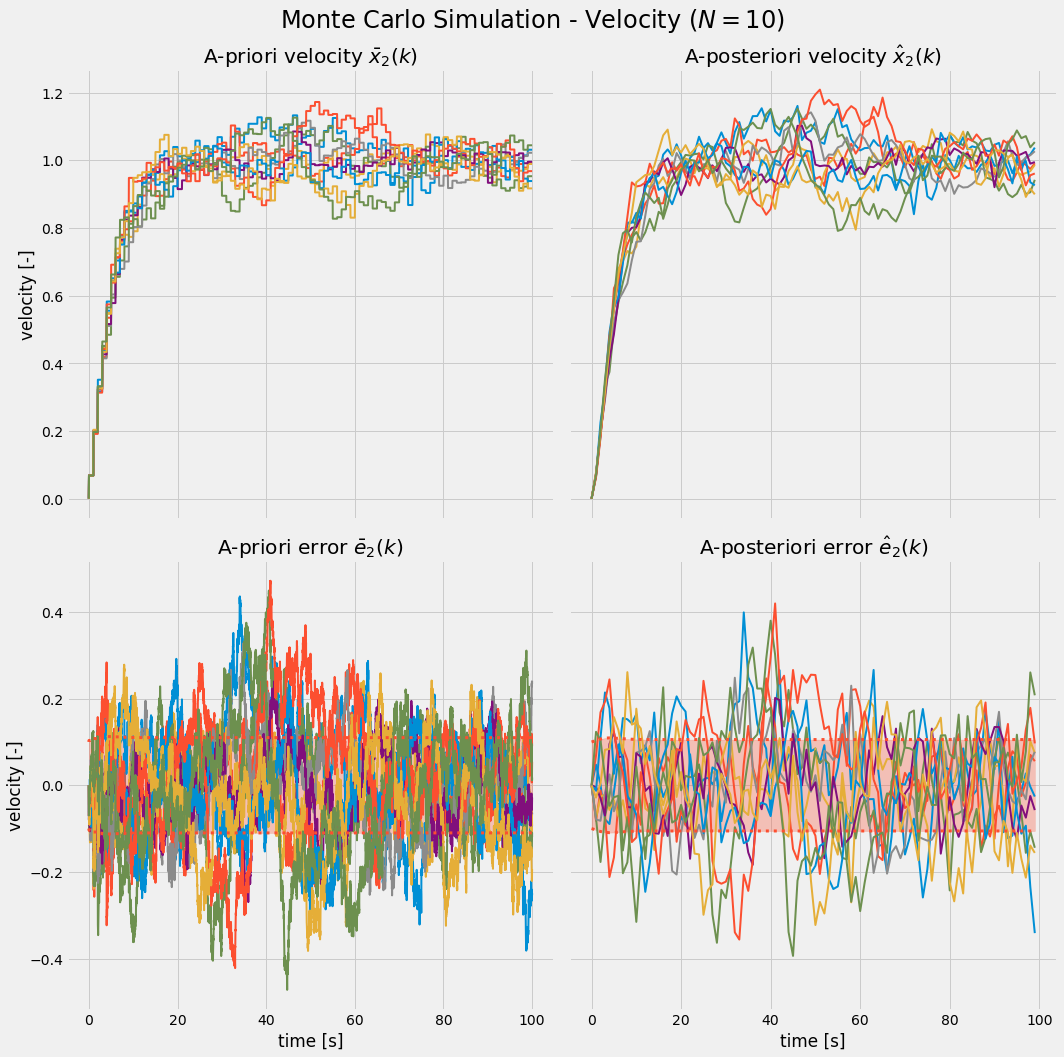

In [64]:
fig, axes = plt.subplots(ncols=2, nrows=2, sharex='col', sharey='row', figsize=(15,15))
fig.suptitle(r'Monte Carlo Simulation - Velocity ($N=10$)', fontsize=24)

tm = np.linspace(t0, tf, nm, endpoint=False)

ax = axes[0,0]
ax.set_title(r'A-priori velocity $\bar{x}_2(k)$')
ax.plot(t, X_bar[:,1,:].T, lw=2)
ax.set_ylabel('velocity [-]')

ax = axes[0,1]
ax.set_title(r'A-posteriori velocity $\hat{x}_2(k)$')
ax.plot(tm, X_hat[:,1,:].T, lw=2)

ax = axes[1,0]
ax.set_title(r'A-priori error $\bar{e}_2(k)$')
ax.plot(t, E_bar[:,1,:].T, lw=2)
ax.plot(t, sqrt(p_bar[1]), color=COLORS[1], lw=3, ls=':')
ax.plot(t, -sqrt(p_bar[1]), color=COLORS[1], lw=3, ls=':')
ax.fill_between(t, sqrt(p_bar[1]), -sqrt(p_bar[1]), color=COLORS[1], alpha=.3)
ax.set_ylabel('velocity [-]')
ax.set_xlabel('time [s]')

ax = axes[1,1]
ax.set_title(r'A-posteriori error $\hat{e}_2(k)$')
ax.plot(tm, E_hat[:,1,:].T, lw=2)
ax.plot(tm, sqrt(p_hat[1]), color=COLORS[1], lw=3, ls=':')
ax.plot(tm, -sqrt(p_hat[1]), color=COLORS[1], lw=3, ls=':')
ax.fill_between(tm, sqrt(p_hat[1]), -sqrt(p_hat[1]), color=COLORS[1], alpha=.3)
ax.set_xlabel('time [s]')

fig.tight_layout()
plt.show()

100%|██████████| 1000/1000 [02:50<00:00,  5.86it/s]


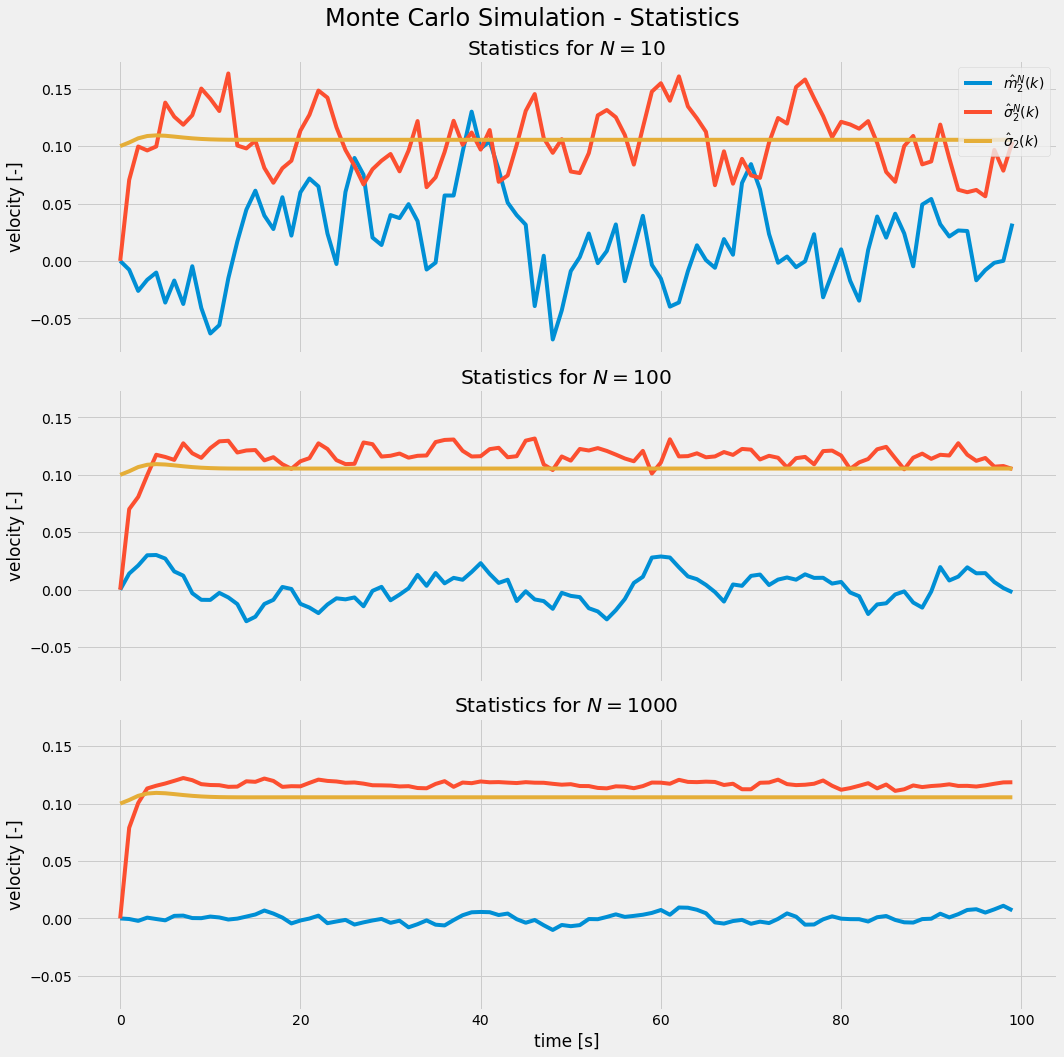

In [72]:
fig, axes = plt.subplots(ncols=1, nrows=3, sharex=True, sharey=True, figsize=(15,15))
fig.suptitle(r'Monte Carlo Simulation - Statistics', fontsize=24)

tm = np.linspace(t0, tf, nm, endpoint=False)

for i, N in enumerate((10,100,1000)):
    (X_bar, X_hat, E_bar, E_hat, p_bar, p_hat) = monte_carlo(N)
    
    ax = axes[i]
    ax.set_title(fr'Statistics for $N={{{N}}}$')
    ax.plot(tm, E_hat[:,1,:].mean(axis=0))
    ax.plot(tm, E_hat[:,1,:].std(axis=0))
    ax.plot(tm, sqrt(p_hat[1]))
    ax.set_ylabel('velocity [-]')

    if i == 0:
        ax.legend([r'$\hat{m}_2^N(k)$', r'$\hat{\sigma}_2^N(k)$', r'$\hat{\sigma}_2(k)$'], loc='upper right')

    
ax.set_xlabel('time [s]')

fig.tight_layout()
plt.show()

# 6 Error budget for optimal Kalman filter

In [19]:
def error_variance(Fi, Ga, P0, H, R, n):
    
    # Model order
    p, _ = Fi.shape
    I = np.eye(p)

    # Covariance matrice estimates
    P_bar = np.zeros((n,p,p))  # a-priori
    P_bar[0,...] = P0
    P_hat = np.zeros((n-1,p,p))  # a-posteriori
    
    for k in range(n-1):
        # Compute Kalman gain
        Kk = P_bar[k,...]@H.T@inv(H@P_bar[k,...]@H.T + R)
        
        # Update a-posteriori estimate
        P_hat[k,...] = (I - Kk@H)@P_bar[k,...]@(I - Kk@H).T + Kk@R@Kk.T

        # Update a-priori estimate
        P_bar[k+1,...] = Fi@P_hat[k,...]@Fi.T + Ga@Ga.T
        
    # Extract diagonals
    p_hat = np.array([P_hat[:,i,i] for i in range(p)])
    
    return p_hat

In [20]:
# Measurement update interval
mi = 100
nm = 101

# Kalman filter model matrices
FiK, _, GaK = c2d_stochastic(F, L, G, Q, dt*mi)
variances = error_variance(FiK, GaK, P0, H, R, nm)

In [21]:
std_tot = norm(variances, axis=0)
std_pos, std_vel, std_cur = variances

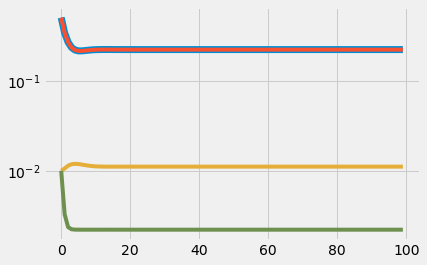

In [22]:
plt.plot(std_tot, lw=7)
plt.plot(std_pos)
plt.plot(std_vel)
plt.plot(std_cur)
plt.yscale('log')

# 7 Suboptimal Kalman filter

In [23]:
# Filter model matrices
Qf = T3/2*Q[:2,:2]
Ff = np.array([[0, 1],
               [0, -1/T2]])
Lf = np.array([[0, 0],
               [0, 1/T2]])
Gf = np.array([[0, 0],
               [0, 1/T2]])
P0f = np.diag([1,.1**2])

# Measurement parameters
Rf = 1*np.eye(2)
Hf = np.array([[1, 0],
               [0, 0]])

In [24]:
# Measurement update interval
mi = 100
nm = 101

# Kalman filter model matrices
FiK, LaK, GaK = c2d_stochastic(Ff, Lf, Gf, Qf, dt*mi)
variances = error_variance(FiK, GaK, P0f, Hf, Rf, nm)

In [25]:
std_tot_s = norm(variances, axis=0)
std_pos_s, std_vel_s = variances

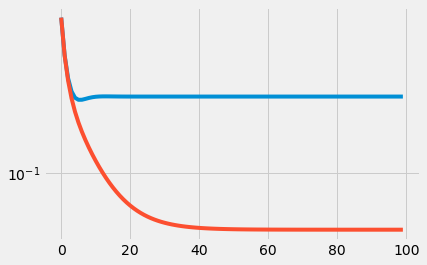

In [26]:
plt.plot(std_pos)
plt.plot(std_pos_s)
plt.yscale('log')